# What is Survival Analysis?

[Survival analysis](https://en.wikipedia.org/wiki/Survival_analysis) is used to study the **time** until some **event** of interest (often referred to as **death**) occurs.  Time could be measured in years, months, weeks, days, etc.  The event could be anything of interest.  It could be an actual death, a birth, a Pokemon Go server crash, etc. In this post we are interested in how long drafted NFL players are in the league, so the event of interest will be the retirement of drafted NFL players. The duration of time leading up to the event of interest can be called the **survival time**. In our case, the survival time is the number of years that a player was active in the league (according to [Pro Football Reference](http://www.pro-football-reference.com/)).  

Some of the players in this analysis are still active players (e.g. Aaron Rodgers, Eli Manning, etc.), so we haven't observed their retirement (the event of interest).  Those players are considered **censored**. While we have some information about their career length (or survival time), we don't know the full length of their career.  This specific type of censorship, one in which we do not observe end of the survival time, is called **right-censorship**.  The methods developed in the field of survival analysis were created in order to deal with the issue of censored data.  In this post we will use one such method, called the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator), to estimate the survival function and construct the survival curve for an NFL career.


## A brief comment on the data used

I used the draft data scraped from my [previous post](http://savvastjortjoglou.com/nfl-draft.html). The duration of a player's career is just the difference between "To" value from the [PFR draft table](http://www.pro-football-reference.com/years/2015/draft.htm) and the year the player was drafted.  Players were considered active, if there name was in bold.  However there are may be some players who are retired that PFR still considers active (e.g. Mike Kafka). You can check out how I prepared the data in [this Jupyter notebook](https://github.com/savvastj/nfl_survival_analysis/blob/master/Data_Prep.ipynb). Let me know if you see any issues/mistakes I've made.

# What is the Survival Function?

The [survival function](https://en.wikipedia.org/wiki/Survival_function), $S(t)$, of a population is defined as follows:

$$S(t) = Pr(T > t)$$

Capital $T$ is a [random variable](https://www.khanacademy.org/math/probability/random-variables-topic/random-variables-prob-dist/v/random-variables) that represents a subject's survival time. In our case $T$ represents an NFL player's career length. Lower case $t$ represents a specific time of interest for $T$. In our analysis the $t$ represents a specific number of years played. In other words the survival function just gives us the probability that someone survives longer than (or at least as long as) a specified value of time, $t$.  So in the context of our analysis, $S(3)$ will provide us the probability that an NFL career lasts longer than 3 years.

# What is the Kaplan-Meier estimator?

To estimate the survival function of NFL players we will use the Kaplan-Meier estimator.  The Kaplan-Meier estimator is defined by the following product (from the [`lifelines` documentation](https://lifelines.readthedocs.io/en/latest/Intro%20to%20lifelines.html#estimating-the-survival-function-using-kaplan-meier)):

$$\hat{S}(t) = \prod_{t_i \lt t} \frac{n_i - d_i}{n_i}$$

where $d_i$ are the number of death events at time $t$ and $n_i$ is the number of subjects at risk of death just prior to time $t$. 

We will walk through a simple example in a bit in order to get a better understanding of the above definition.

# Estimating the Survival Function of NFL Players

To estimate the survival function of NFL players we will be using the [`lifelines` library](https://lifelines.readthedocs.io/en/latest/index.html).  It provides a user friendly interface for survival analyis using Python. Lets get started by importing what we need and reading in the data.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

draft_df = pd.read_csv("data/nfl_survival_analysis_data.csv")

# set some plotting aesthetics, similar to ggplot
sns.set(palette = "colorblind", font_scale = 1.35, 
        rc = {"figure.figsize": (12,9), "axes.facecolor": ".92"})

In [2]:
draft_df.head()

,Draft_Yr,Rnd,Pick,Tm,Player,Pos,Age,To,AP1,PB,...,Rec,Rec_Yds,Rec_TD,Tkl,Def_Int,Sk,College,Player_ID,Retired,Duration
0,1967,1,1,BAL,Bubba Smith,DE,22,1976,1,2,...,0,0,0,0.0,0,0.0,Michigan St.,SmitBu00,1,10
1,1967,1,2,MIN,Clint Jones,RB,22,1973,0,0,...,38,431,0,0.0,0,0.0,Michigan St.,JoneCl00,1,7
2,1967,1,3,SFO,Steve Spurrier,QB,22,1976,0,0,...,0,0,0,0.0,0,0.0,Florida,SpurSt00,1,10
3,1967,1,4,MIA,Bob Griese,QB,22,1980,2,8,...,0,0,0,0.0,0,0.0,Purdue,GrieBo00,1,14
4,1967,1,5,HOU,George Webster,LB,21,1976,3,3,...,0,0,0,0.0,5,0.0,Michigan St.,WebsGe00,1,10


The columns of interest for our analysis are the *Duration* and *Retired* columns.  The *Duration* column represents the number of years a player played in the NFL.  The *Retired* column represents whether the player retired from the NFL or not.  1 indicates that he is retired, while 0 indicates that he is still an active player.

To calculate the Kaplan-Meier estimate we will need to create a `KaplanMeierFitter` object.

In [3]:
kmf = KaplanMeierFitter() 

We can then fit the data by calling the `KaplanMeierFitter`s `fit` method.

In [4]:
# The 1st arg accepts an array or pd.Series of individual survival times
# The 2nd arg accepts an array or pd.Series that indicates if the event 
# interest (or death) occured.
kmf.fit(durations = draft_df.Duration, 
        event_observed = draft_df.Retired)

<lifelines.KaplanMeierFitter: fitted with 15592 observations, 1629 censored>

After fitting our data we can access the event table that contains a bunch of information regarding the subjects (the NFL players) at each time period.

In [5]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0,4597.0,4504.0,93.0,15592.0,15592.0
1,1310.0,1076.0,234.0,0.0,10995.0
2,1415.0,1176.0,239.0,0.0,9685.0
3,1183.0,952.0,231.0,0.0,8270.0
4,1126.0,942.0,184.0,0.0,7087.0
5,967.0,822.0,145.0,0.0,5961.0
6,915.0,782.0,133.0,0.0,4994.0
7,823.0,715.0,108.0,0.0,4079.0
8,743.0,667.0,76.0,0.0,3256.0


The *removed* column contains the number of observations removed during that time period, whether due to death (the value in the *observed* column) or censorship. So the *removed* column is just the sum of the *observed* and *censorship* columns.  The *entrance* column tells us whether any new subjects entered the population at that time period.  Since all the players we are studying start at $time = 0$ (the moment they were drafted), the *entrance* value is 15,592 at that time and 0 for all other times.

The *at_risk* column contains the number of subjects that are still alive during a given time. The value for *at_risk* at $time = 0$, is just equal to the *entrance* value.  For the remaining time periods, the *at_risk* value is equal to the difference between the time previous period's *at_risk* value and *removed* value, plus the current period's *entrance* value. For example for $time = 1$, the number of subject's *at risk*  is 10,995 which is equal to 15,592 (the previous *at_risk* value) - 4,597 (the previous *removed* value) + 0 (the current period's *entrance* value).

Since we have access to the survival table we can calculate the survival probability at different times "by hand."

Let us take a look at the definition of the Kaplan-Meier Estimate again:

$$\hat{S}(t) = \prod_{t_i \lt t} \frac{n_i - d_i}{n_i}$$

where  $d_i$  are the number of death events at time  $t$  and  $n_i$  is the number of subjects at risk of death just prior to time  $t$. 

What the above essentially tells us is that the value of the survival function for time $t$, is the product of the survival probabilities for all individual time periods leading up to time $t$. 

We can define the survival probability for an individual time period as follows:

$$S_t = \frac{\substack{\text{Number of subjects} \\ \text{at risk at the start}} - \substack{\text{Number of subjects} \\ \text{that died}}}{\substack{\text{Number of subjects} \\ \text{at risk at the start}}}$$

**NOTE** the number of deaths in the above formula does not include the number of censored observations.  

Lets walk through a simple example and calculate the the probability that an NFL career lasts longer than 2 years. First we calculate the individual survival probabilities for $t = 0$, $t = 1$, and $t = 2$. 

Here's the calculation for the survival probability time for $t = 0$:

$$S_0 = \frac{\substack{\text{Number of players at risk at the start} \\ \text{(i.e. Number of players drafted)}} - \substack{\text{Number of players} \\ \text{that immediately failed}}}{\substack{\text{Number of players at risk at the start} \\ \text{(i.e. Number of players drafted)}}} = \frac{15,592 - 4,504}{15,592} = \frac{11,088}{15,592} \approx 0.711$$

And the code for the calculation:

In [6]:
# get the values for time = 0 from the survival table
event_at_0 = kmf.event_table.iloc[0, :]
# now calculate the survival probability for t = 0
surv_for_0 =  (event_at_0.at_risk - event_at_0.observed) / event_at_0.at_risk
surv_for_0

0.71113391482811694

What the above means is that about 71.1% of players drafted make it on to the field. 

Now the individual survival probability for $t = 1$:

$$S_1 = \frac{\substack{\text{Number of players} \\ \text{that survive the draft}} - \substack{\text{Number of players} \\ \text{that failed in the 1st year}}}{\substack{\text{Number of players} \\ \text{that survive the draft}}} = \frac{10,995 - 1,076}{10,995} = \frac{9,919}{10,995} \approx 0.902$$

In [7]:
# Calculate the survival probability for t = 1
event_at_1 = kmf.event_table.iloc[1, :]
surv_for_1 =  (event_at_1.at_risk - event_at_1.observed) / event_at_1.at_risk
surv_for_1

0.90213733515234196

The value for $S_1$ represents the conditional probability that if a player does not immediately fail once drafted, then he has a 90.2% chance of playing 1 year of football. 

Below is the calculation for $S_2$:

$$S_2 = \frac{\substack{\text{Number of players that survive the} \\ \text{1st year and are entering the 2nd year}} - \substack{\text{Number of players} \\ \text{that failed in the 2nd year}}}{\substack{\text{Number of players that survive the} \\ \text{1st year and are entering the 2nd year}}} = \frac{9,685 - 1,176}{9,685} = \frac{8,509}{9,685} \approx 0.879$$

In [8]:
# Calculate the survival probability for t = 2
event_at_2 = kmf.event_table.iloc[2, :]
surv_for_2 =  (event_at_2.at_risk - event_at_2.observed) / event_at_2.at_risk
surv_for_2

0.87857511615900874

$S_2$ also represents a conditional probability.  It is the probability that a player plays in their 2nd year given that he did not retire after his 1st year.  This ends up being about 87.9%.

Finally to calculate the probability that an NFL career will last more than 2 years, we just multiply the three individual survival probabilities:

$$S(2) = S_0 \times S_1 \times S_2 = \frac{11,088}{15,592} \times \frac{9,919}{10,995} \times \frac{8,509}{9,685}  \approx 0.564$$

In [9]:
# The probability that an NFL player has a career longer than 2 years
surv_after_2 = surv_for_0 * surv_for_1 * surv_for_2
surv_after_2

0.56364147964887967

So we see that drafted players have about a 56.4% chance of making it past their 2nd year, or having a career as long as 2 years. Hopefully going through that short example gives you a better idea of how the Kaplan-Meier estimator works.  

Our `KaplanMeierFitter` object  has already done all of the above calculations for us. We can get the survival probability after a given time by simply using the `predict` method. So to get the value for $S(2)$ we just pass in 2 into the `predict` method.

In [10]:
kmf.predict(2)

0.56364147964887934

That's pretty close to the value we calculated by hand.  (I'm not sure why they aren't exactly the same. Possibly a  rounding issue? If you do know why please let me know).

The `predict` method can also handle an array of numbers, returning an array of probabilities.

In [11]:
# The survival probabilities of NFL players after 1, 3, 5, and 10 yrs played
kmf.predict([1,3,5,10])

array([ 0.64154045,  0.49875796,  0.37282823,  0.11208943])

To get the full list of estimated probabilities from our `KaplanMeierFitter`, access the `survival_function_` attribute.

In [12]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,0.711134
1.0,0.641540
2.0,0.563641
3.0,0.498758
4.0,0.432463
5.0,0.372828
6.0,0.314448
7.0,0.259329
8.0,0.206205


The `median_` attribute also provides us the number of years where on average 50% of players are out of the league.

In [13]:
kmf.median_

3.0

## Plotting the Kaplan-Meier Estimate

Plotting the Kaplan-Meier estimate (along with its confidence intervals) is pretty straightfoward. All we need to do is call the `plot` method.

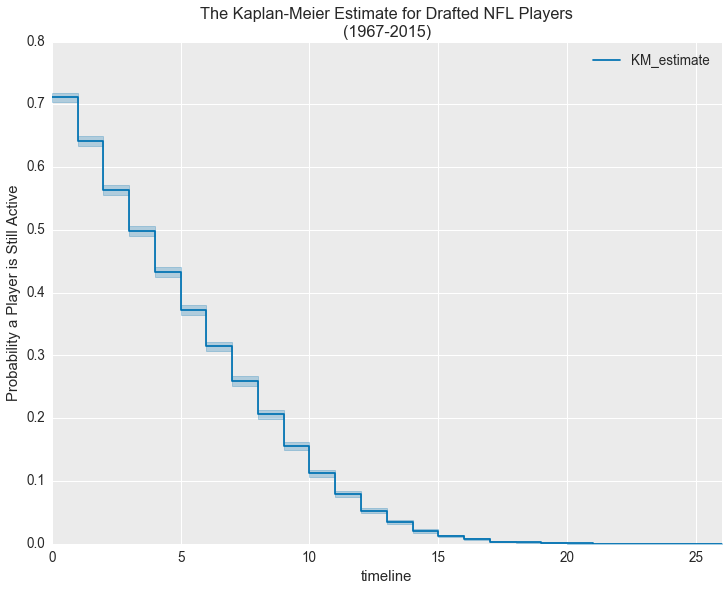

In [14]:
# plot the KM estimate
kmf.plot()
# Add title and y-axis label
plt.title("The Kaplan-Meier Estimate for Drafted NFL Players\n(1967-2015)")
plt.ylabel("Probability a Player is Still Active")

plt.show()

The first thing thing that you should notice is that the Kaplan-Meier estimate is a step function.  Each horizontal line represents the probability that a player is still active after a given time $t$.  For example, when $t = 0$, the probability that a player is still active after that point is about 71%.

### Plotting the Kaplan-Meier Estimate by Position

Before we plot the career lengths by position, lets clean up some of the data.  We will merge and drop some of the player positions in order to make the plotting a bit more manageable.

In [15]:
draft_df.Pos.unique() # check out all the different positions

array(['DE', 'RB', 'QB', 'LB', 'WR', 'C', 'T', 'DT', 'G', 'HB', 'DB', 'TE',
       'K', 'FL', 'E', 'P', 'FB', 'WB', 'NT', 'KR', 'OL', 'DL', 'OLB',
       'CB', 'FS', 'ILB', 'SS', 'S', 'LS'], dtype=object)

In [16]:
draft_df.Pos.value_counts() # get a count for each position

DB     2668
LB     2039
RB     1798
WR     1793
DE     1242
T      1174
G      1028
DT      987
TE      873
QB      722
C       450
K       197
P       156
NT      134
FB       91
FL       63
OL       39
CB       29
E        29
OLB      23
HB       23
ILB      11
SS        7
FS        5
DL        4
KR        3
WB        2
LS        1
S         1
Name: Pos, dtype: int64

In [17]:
# Relabel/Merge some of the positions
# Set all HBs to RB
draft_df.loc[draft_df.Pos == "HB", "Pos"] = "RB"

# Set all Safeties and Cornernbacks to DBs
draft_df.loc[draft_df.Pos.isin(["SS", "FS", "S", "CB"]), "Pos"] = "DB"

# Set all types of Linebackers to LB
draft_df.loc[draft_df.Pos.isin(["OLB", "ILB"]), "Pos"] = "LB"

In [18]:
# drop players from the following positions [FL, E, WB, KR, LS, OL]
# get the row indices for players with undesired postions
idx = draft_df.Pos.isin(["FL", "E", "WB", "KR", "LS", "DL", "OL"])
# keep the players that don't have the above positions
draft_df_2 = draft_df.loc[~idx, :]

In [19]:
# check the number of positions in order to decide
# on the plotting grid dimiensions
len(draft_df_2.Pos.unique())

15

Now that we have the data organized, lets plot the Kaplan-Meier estimate for each position.  I've commented the code below to walk you through the process of plotting each position in a 5x3 plotting grid.

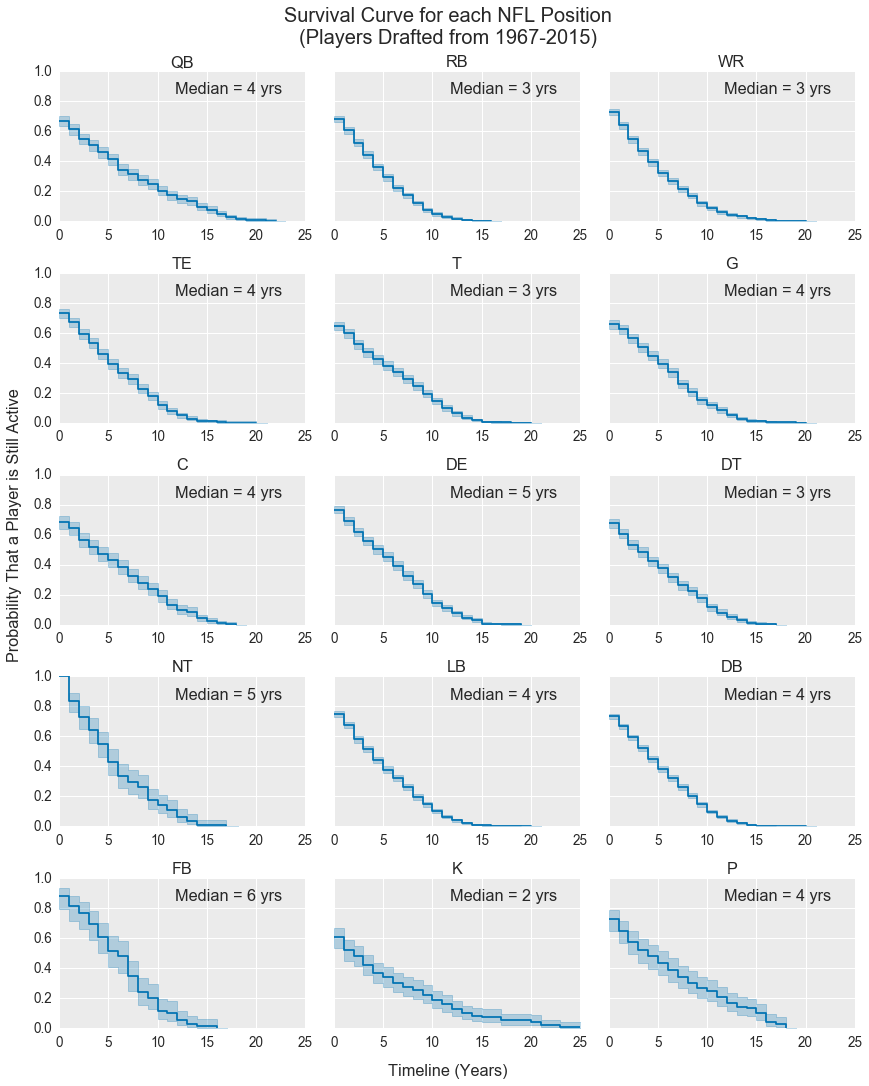

In [20]:
# create a new KMF object
kmf_by_pos = KaplanMeierFitter()

duration = draft_df_2.Duration
observed = draft_df_2.Retired

# Set the order that the positions will be plotted
positions = ["QB", "RB", "WR",
             "TE", "T", "G", 
             "C", "DE", "DT", 
             "NT", "LB", "DB",
             "FB", "K", "P"]

# Set up the the 5x3 plotting grid by creating figure and axes objects
# Set sharey to True so that each row of plots share the left most y-axis labels
fig, axes = plt.subplots(nrows = 5, ncols = 3, sharey = True,
                         figsize=(12,15))

# flatten() creates a 1-D array of the individual axes (or subplots)
# that we will plot on in our grid
# We zip together the two 1-D arrays containing the positions and axes
# so we can iterate over each postion and plot its KM estimate onto 
# its respective axes
for pos, ax in zip(positions, axes.flatten()):
    # get indices for players with the matching position label
    idx = draft_df_2.Pos == pos
    # fit the kmf for the those players
    kmf_by_pos.fit(duration[idx], observed[idx])
    # plot the KM estimate for that position on its respective axes
    kmf_by_pos.plot(ax=ax, legend=False)
    # place text indicating the median for the position
    # the xy-coord passed in represents the fractional value for each axis
    # for example (.5, .5) places text at the center of the plot
    ax.annotate("Median = {:.0f} yrs".format(kmf_by_pos.median_), xy = (.47, .85), 
                xycoords = "axes fraction")
    # get rid the default "timeline" x-axis label set by kmf.plot() 
    ax.set_xlabel("")
    # label each plot by its position
    ax.set_title(pos)
    # set a common x and y axis across all plots
    ax.set_xlim(0,25)
    ax.set_ylim(0,1)

# tighten up the padding for the subplots
fig.tight_layout()

# https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots
# set a common x-axis label
fig.text(0.5, -0.01, "Timeline (Years)", ha="center")
# set a common y-axis label
fig.text(-0.01, 0.5, "Probability That a Player is Still Active", 
         va="center", rotation="vertical")
# add the title for the whole plot
fig.suptitle("Survival Curve for each NFL Position\n(Players Drafted from 1967-2015)",
             fontsize=20)
# add some padding between the title and the rest of the plot to avoid overlap
fig.subplots_adjust(top=0.92)

plt.show()

## Checking the Conditional Survival Time

Another interesitng attribute in our `KaplanMeierFitter` is the `conditional_time_to_event_`.  It is a `DataFrame` that contains the estimated median remaining lifetime, conditioned on surviving up to time $t$.  So from the table below we see that if a player is in the league for 1 year, their expected remaining career length is 5 years.  Please note that some of the conditional survival times for later time values are a bit funky due to the smaller sample sizes of those time periods.

In [21]:
kmf._conditional_time_to_event_()

,KM_estimate - Conditional time remaining to event
timeline,
0.0,6.0
1.0,5.0
2.0,5.0
3.0,5.0
4.0,4.0
5.0,4.0
6.0,3.0
7.0,3.0
8.0,3.0


# Resources

Here are the resources I used to help write up this post and learn about survival analysis:

## Papers, Articles, and Documentation
- [The `lifelines` documentation](https://lifelines.readthedocs.io/en/latest/index.html)
- [The PDF to the original paper by Kapalan and Meier](http://www.csee.wvu.edu/~xinl/library/papers/math/statistics/kaplan.pdf)
- [Survival Analysis: A Self Learning Text](https://www.amazon.com/Survival-Analysis-Self-Learning-Statistics-Biology/dp/1441966455)
- [A Practical Guide to Understanding Kaplan-Meier Curves](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3932959/)
- [Understanding survival analysis: Kaplan-Meier estimate](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3059453/)
- [What is Survival Analysis (PDF)](https://www.cscu.cornell.edu/news/statnews/stnews78.pdf)
- [A short article by Kaplan](http://www.garfield.library.upenn.edu/classics1983/A1983QS51100001.pdf)

## Videos
- [Lifelines: Survival Analysis in Python](https://www.youtube.com/watch?v=XQfxndJH4UA), by Cameron Davidson-Pilon (the creator of the `lifelines` library)
- [Survival Analysis in Python and R](https://www.youtube.com/watch?v=fli-yE5grtY), by Linda Uruchurtu

As always you can find my code and data on [github](https://github.com/savvastj/nfl_survival_analysis).  Please let me know if you see any mistakes/issues or have any suggestions on improving this post.